## 1. 데이터 준비

In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy
import pickle

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_not_contain_every_class, split_contain_every_class, generate_server_idcs, CustomSubset, split_noniid


torch.manual_seed(42)
np.random.seed(42)


In [2]:
COMMUNICATION_ROUNDS = 50
EPS_1 = 0.4
EPS_2 = 1.6
N_CLIENTS = 9

total_client_data = 1000
data_per_class = 50
ALPHA = 1

In [3]:
data = datasets.MNIST(root="MNIST/", download=False)

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

idcs = np.random.permutation(len(data))

In [4]:
def do_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*1.5)], idcs[int(total_client_data*1.5):]
    train_labels = data.train_labels.numpy()
    test_labels = data.train_labels.numpy()[int(total_client_data*1.5):]

    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)#, data_per_class=int(total_client_data/10))
    server_idcs = generate_server_idcs(test_idcs, test_labels)

    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)

    
    distillation_data_file = f'distillation_data_{data_per_class}_per_class.pth'

    # Check if the file already exists
    if not os.path.exists(distillation_data_file):
        # The file does not exist, generate and save the distillation data
        distillation_data = server.make_distillation_data(data_per_class=data_per_class)
        torch.save(distillation_data, distillation_data_file)

    # Load the distillation data
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    def aggregate(cluster_indices_new):
        cluster_indices = cluster_indices_new
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

        server.aggregate_clusterwise(client_clusters)

        return cluster_indices

    cfl_stats = ExperimentLogger()

    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


    for c_round in range(1, COMMUNICATION_ROUNDS+1):

        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            if c_round == 1:
                client.distill()

            train_stats = client.compute_weight_update(epochs=1) #train client

            if c_round == 1000:
                client.reset()

        cluster_indices_new = []

        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

            #cluster 나누는 기준
            if c_round == COMMUNICATION_ROUNDS: #무조건 한번 나누기
                similarities = server.compute_pairwise_similarities(clients)

                server.cache_model(idc, clients[idc[0]].W, acc_clients)

                c1, c2, c3 = server.cluster_clients_GMM(similarities[idc][:,idc])
                cluster_indices_new += [c1, c2, c3]

        if c_round == 1000:
            cluster_indices = aggregate(cluster_indices_new)

        acc_clients = [client.evaluate() for client in clients]

        if c_round == COMMUNICATION_ROUNDS: #무조건 한번 나누기
            label_accuracies = pd.DataFrame()
            label_predicted = pd.DataFrame()
            label_soft_sum = pd.DataFrame()
            label_diff = pd.DataFrame()

            for i, client in enumerate(clients):
                acc, pred, sum_, diff = server.evaluate(client.model)
                # Convert each dictionary to a DataFrame and append to the respective DataFrame
                label_accuracies = label_accuracies.append(pd.DataFrame(acc, index=[i]))
                label_predicted = label_predicted.append(pd.DataFrame(pred, index=[i]))
                label_soft_sum = label_soft_sum.append(pd.DataFrame(sum_, index=[i]))
                label_diff = label_diff.append(pd.DataFrame(diff, index=[i]))

            # Reset index for all DataFrames
            label_accuracies.reset_index(drop=True, inplace=True)
            label_predicted.reset_index(drop=True, inplace=True)
            label_soft_sum.reset_index(drop=True, inplace=True)
            label_diff.reset_index(drop=True, inplace=True)

        if c_round == 1:
            first_accuracies = pd.DataFrame()
            for i, client in enumerate(clients):
                first_acc, pred, sum_, diff = server.evaluate(client.model)
                first_accuracies = first_accuracies.append(pd.DataFrame(first_acc, index=[i]))
            first_accuracies = first_accuracies.fillna(0)

            client_acc_after_distill = sum(acc_clients)/len(acc_clients)
            global_acc_after_distill = np.mean(np.ravel(first_accuracies.values))


        elif c_round == COMMUNICATION_ROUNDS:
            client_acc_final = sum(acc_clients)/len(acc_clients)
            global_acc_final = np.mean(np.ravel(label_accuracies.values))

        average_dw = server.get_average_dw(clients)
        #print(average_dw)
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                      "rounds" : c_round, "clusters" : cluster_indices, "average_dw": average_dw})


        display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)


    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)
    
    client_acc_after_distill = round(client_acc_after_distill, 3)
    global_acc_after_distill = round(global_acc_after_distill, 3)
    client_acc_final = round(client_acc_final, 3)
    global_acc_final = round(global_acc_final, 3)
    
    return client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final

    print(client_acc_after_distill, global_acc_after_distill)
    print(client_acc_final, global_acc_final)

In [5]:
#client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final = do_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA)

## 1) test 코드

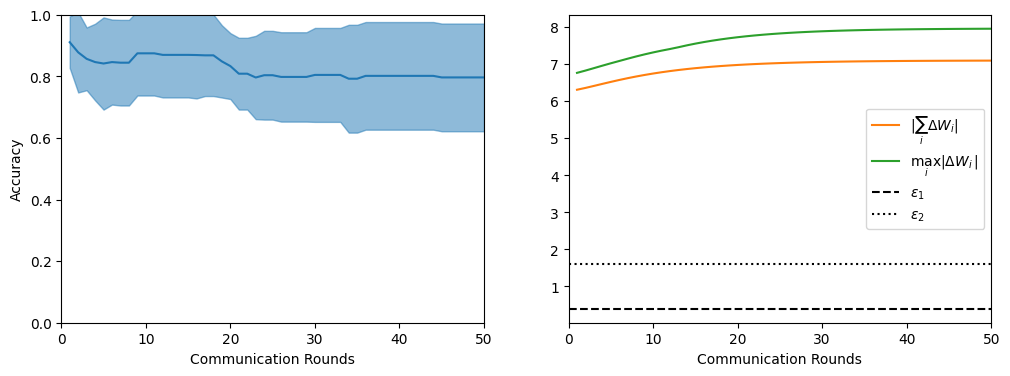

In [6]:
# Define the directory where you want to save the results
save_dir = 'results/data_amount'
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Define the different total_client_data values
total_client_data_values = [100, 200, 500]

results = {}

# Loop over the total_client_data values
for total_client_data in total_client_data_values:
    # Call the function and save the results
    client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final = do_experiments(
        total_client_data=total_client_data, 
        data_per_class=data_per_class, 
        ALPHA=ALPHA
    )

    # Save the results in the results dictionary
    results[total_client_data] = {
        'client_acc_after_distill': client_acc_after_distill, 
        'global_acc_after_distill': global_acc_after_distill, 
        'client_acc_final': client_acc_final, 
        'global_acc_final': global_acc_final
    }

# Save the results dictionary to disk
with open(os.path.join(save_dir, 'results_070314.pkl'), 'wb') as f:
    pickle.dump(results, f)


## 2)client, server 데이터 양 확인 1차 실험

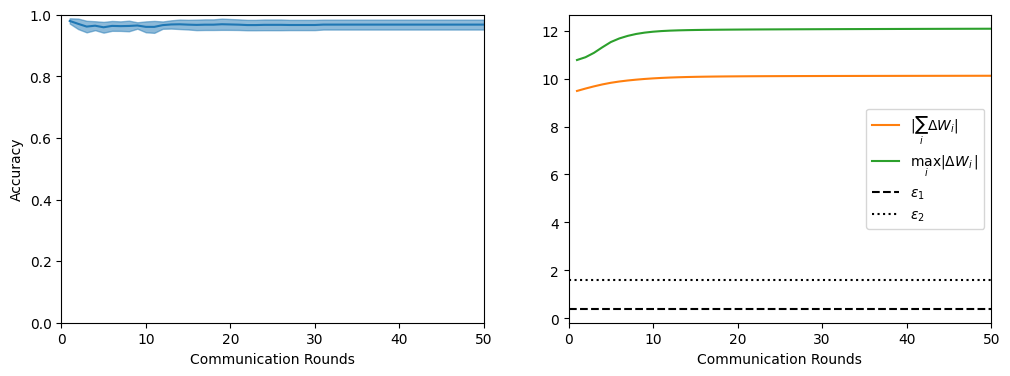

In [7]:
# Define the directory where you want to save the results
save_dir = 'results/data_amount'
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Define the different total_client_data, data_per_class, and ALPHA values
total_client_data_values = [200, 500, 1000, 2000, 5000]
data_per_class_values = [10, 20, 50, 100, 200, 500]

results = {}

# Loop over the total_client_data and data_per_class values
for data_per_class in data_per_class_values:
    for total_client_data in total_client_data_values:
            
        temp_results = []

        # Repeat the experiment twice
        for _ in range(2):
            # Call the function and save the results
            client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final = do_experiments(
                total_client_data=total_client_data, 
                data_per_class=data_per_class, 
                ALPHA=ALPHA
            )

            # Store the results in a temporary list
            temp_results.append({
                'client_acc_after_distill': client_acc_after_distill, 
                'global_acc_after_distill': global_acc_after_distill, 
                'client_acc_final': client_acc_final, 
                'global_acc_final': global_acc_final
            })

        # Calculate the average of the results
        avg_results = {
            key: np.mean([res[key] for res in temp_results]) 
            for key in temp_results[0]
        }

        # Save the average results in the results dictionary
        results[(total_client_data, data_per_class, ALPHA)] = avg_results

    # Save the results dictionary to disk after each data_per_class
    with open(os.path.join(save_dir, f'results_070221_client_server_data_amount_class_{data_per_class}.pkl'), 'wb') as f:
        pickle.dump(results, f)

In [10]:
import os
import pickle
import pprint

# Define the directory where the results are saved
save_dir = 'results/data_amount'

# Define the different data_per_class values
data_per_class_values = [10, 20, 50, 100, 200, 500]

# For pretty printing
pp = pprint.PrettyPrinter(indent=4)

# Loop over the data_per_class values
for data_per_class in data_per_class_values:
    # Load the results from the pickle file
    with open(os.path.join(save_dir, f'results_070221_client_server_data_amount_class_{data_per_class}.pkl'), 'rb') as f:
        results = pickle.load(f)

    print(f"\nResults for data_per_class={data_per_class}:")
    pp.pprint(results)



Results for data_per_class=10:
{   (200, 10, 1): {   'client_acc_after_distill': 0.7685,
                      'client_acc_final': 0.6075,
                      'global_acc_after_distill': 0.6745,
                      'global_acc_final': 0.387},
    (500, 10, 1): {   'client_acc_after_distill': 0.7765,
                      'client_acc_final': 0.744,
                      'global_acc_after_distill': 0.677,
                      'global_acc_final': 0.5515},
    (1000, 10, 1): {   'client_acc_after_distill': 0.8280000000000001,
                       'client_acc_final': 0.8035,
                       'global_acc_after_distill': 0.745,
                       'global_acc_final': 0.6165},
    (2000, 10, 1): {   'client_acc_after_distill': 0.755,
                       'client_acc_final': 0.804,
                       'global_acc_after_distill': 0.6435,
                       'global_acc_final': 0.668},
    (5000, 10, 1): {   'client_acc_after_distill': 0.7625,
                       'clie

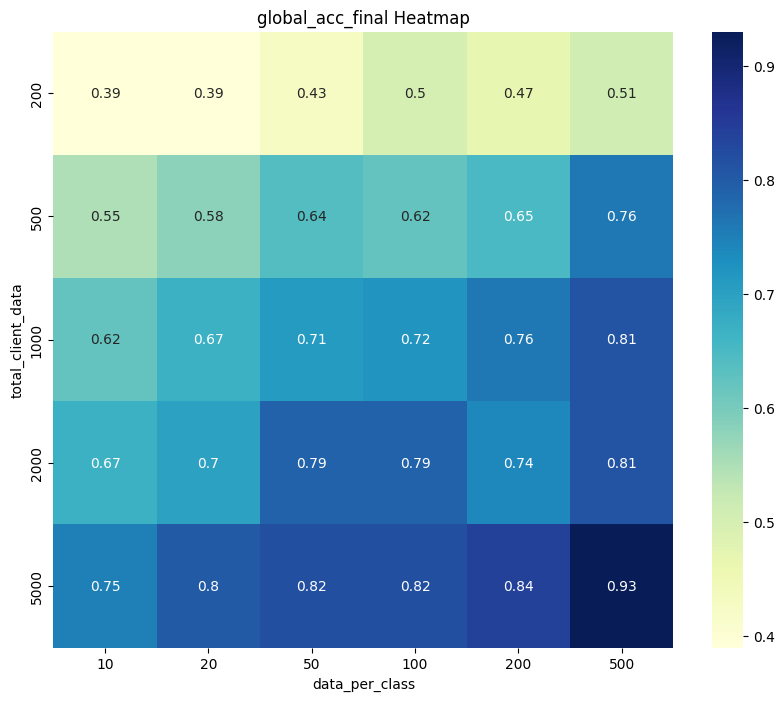

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the different data_per_class values
data_per_class_values = [10, 20, 50, 100, 200, 500]

# Define the total_client_data values
total_client_data_values = [200, 500, 1000, 2000, 5000]

# Metrics
metrics = ['global_acc_after_distill', 'global_acc_final']

# Prepare list to store the rows
data = []

# Fill in the rows
for data_per_class in data_per_class_values:
    with open(os.path.join(save_dir, f'results_070221_client_server_data_amount_class_{data_per_class}.pkl'), 'rb') as f:
        results = pickle.load(f)

    for total_client_data in total_client_data_values:
        for metric in metrics:
            row = {"total_client_data": total_client_data, "metric": metric, "data_per_class": data_per_class, "value": round(results[(total_client_data, data_per_class, 1)][metric], 2)}
            data.append(row)

# Create the DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to the desired shape
df = df.pivot(index=['total_client_data', 'metric'], columns='data_per_class', values='value')

# Filter for 'client_acc_final'
df_final = df.xs('global_acc_final', level='metric')

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_final, annot=True, cmap="YlGnBu")
plt.title('global_acc_final Heatmap')
plt.show()


### 3) 서버, client data 양 2차 실험

In [ ]:
first_accuracies

In [ ]:
label_accuracies.sort_index(axis=1)

In [ ]:
label_soft_sum.sort_index(axis=1)

In [ ]:
label_diff.sort_index(axis=1)

In [ ]:
label_predicted.sort_index(axis=1)

In [ ]:
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(n_components=2)

# Apply PCA to the dataframes
label_accuracies_pca = pca.fit_transform(label_accuracies)
label_predicted_pca = pca.fit_transform(label_predicted)
label_soft_sum_pca = pca.fit_transform(label_soft_sum)
label_diff_pca = pca.fit_transform(label_diff)
transformed_data = pca.fit_transform(similarities)

# Create labels
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plots with larger dots
dot_size = 50
axs[0, 0].scatter(label_accuracies_pca[:, 0], label_accuracies_pca[:, 1], c=labels, s=dot_size)
axs[0, 0].set_title('Label Accuracies')
axs[0, 1].scatter(label_predicted_pca[:, 0], label_predicted_pca[:, 1], c=labels, s=dot_size)
axs[0, 1].set_title('Label Predicted')
axs[1, 0].scatter(label_soft_sum_pca[:, 0], label_soft_sum_pca[:, 1], c=labels, s=dot_size)
axs[1, 0].set_title('Label Soft Sum')
axs[1, 1].scatter(label_diff_pca[:, 0], label_diff_pca[:, 1], c=labels, s=dot_size)
axs[1, 1].set_title('Label Soft Diff')

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_accuracies = silhouette_score(label_accuracies_pca, labels)
silhouette_predicted = silhouette_score(label_predicted_pca, labels)
silhouette_soft_sum = silhouette_score(label_soft_sum_pca, labels)
silhouette_diff = silhouette_score(label_diff_pca, labels)
silhouette_transformed_data = silhouette_score(transformed_data, labels)

print('Silhouette Score for Accuracies:', silhouette_accuracies)
print('Silhouette Score for Predicted:', silhouette_predicted)
print('Silhouette Score for Soft Sum:', silhouette_soft_sum)
print('Silhouette Score for diff:', silhouette_diff)
print('Silhouette Score for Model params:', silhouette_transformed_data)



In [ ]:
#df.sort_index(axis=1)

데이터 Cluster 별 모델 파라미터 분포

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit and transform your data to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(similarities)

# Assign labels based on index ranges
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 0.35, len(unique_labels)))

# Plot the transformed data with labels
for label, color in zip(unique_labels, colors):
    idx = np.where(labels == label)
    plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], color=color, label=f'Cluster {label}')

# Add a legend
plt.legend()

plt.show()
